In [ ]:
# default_exp dataloader

# dataloader

> API details.

> **All private functions use primitive datatypes**


1. read_image(path: str, channels: int=3)
2. clf.load_from_folder
3. clf.load_from_csv
4. detect.load_from_xml
5. detect.load_from_csv
6. detect.load_from_json
7. detect.load_from_tfrecord

In [ ]:
#hide
from nbdev.showdoc import *

In [ ]:
#hide
import sys
sys.path.append('../')

In [ ]:
#export
import tensorflow as tf
import pathlib
import os

import math
import matplotlib.pyplot as plt

from typing import Union

import chitra
from chitra.core import remove_dsstore
from chitra.image import read_image, resize_image

In [ ]:
#export
AUTOTUNE = tf.data.experimental.AUTOTUNE

In [ ]:
#export
def get_basename(path: tf.string):
    assert isinstance(path, tf.Tensor)
    return tf.strings.split(path, os.path.sep)[-1]


def show_batch(clf, limit: int, figsize: tuple = (10, 10)):
    """Visualize image and labels
    
    https://www.tensorflow.org/tutorials/load_data/images#load_using_keraspreprocessing
    
    Args:
        data: tf.data.Dataset containing image, label
        limit: number of images to display
        figsize: size of visualization
    Returns:
        Displays images and labels
    """
    assert isinstance(limit, int)
    assert isinstance(figsize, tuple)

    data = clf.data
    idx_to_class = clf.idx_to_class

    plt.figure(figsize=figsize)
    sub_plot_size = math.ceil(limit / 2)

    for i, e in enumerate(data.take(limit)):
        image, label = e
        image = image.numpy().astype('uint8')
        label = idx_to_class[label.numpy()] if idx_to_class else label.numpy()

        ax = plt.subplot(sub_plot_size, sub_plot_size, i + 1)

        plt.imshow(image)
        plt.title(label)
        plt.axis('off')

# CLF DLoader

``DataLoader class for loading dataset for image classification tasks.``

## clf.load_from_folder (TODOs)

1. `__len__` method impl
2. `image augmentation` impl

## folder structure

><pre>/root
    /class1_folder
        /img0.jpg img1.jpg img2.jpg ....
    /class2_folder
        /img0.jpg...</pre>

In [ ]:
#export
class Clf(object):

    def __init__(self):
        self.CLASS_NAMES = None
        self.data = None
        self.shape = None
        self.class_to_idx = {}
        self.idx_to_class = {}

        self._lookup_class_to_idx = None

    def _get_image_list(self, path: str):
        """`path`: pathlib.Path
        Returns: list of images
        """
        assert isinstance(path, str)
        list_images = tf.data.Dataset.list_files(f'{path}/*/*')
        return list_images

    def _process_path(self, path: str):
        """
        Args:
            `path` :str
            `size`: None or tuple
        Returns:
            image, label
        """
        assert isinstance(
            path,
            (str,
             tf.Tensor)), f'type of path is {type(path)}, expected type str'
        img = read_image(path)

        # TODO: resizing should be done separately
        # py_function will degrade performance
        if self.shape:
            [
                img,
            ] = tf.py_function(resize_image, [img, self.shape], [tf.float32])

        label = tf.strings.split(path, os.path.sep)[-2]
        label = self._lookup_class_to_idx.lookup(label) if self._lookup_class_to_idx else label
        return img, label

    def _ensure_shape(self, img, labels):
        img = tf.ensure_shape(img, (*self.shape, 3), name='image')
        return img, labels

    def create_lookup_table(self):

        keys = list(self.class_to_idx.keys())
        vals = list(self.class_to_idx.values())

        keys_tensor = keys  #tf.constant(keys)
        vals_tensor = vals  #tf.constant(vals)

        table_init = tf.lookup.KeyValueTensorInitializer(
            keys_tensor, vals_tensor)

        self._lookup_class_to_idx = tf.lookup.StaticHashTable(table_init, -1)

    def _get_classnames(self, list_folders, encode_classes: bool = True):
        self.CLASS_NAMES = tuple(
            get_basename(e).numpy().decode() for e in list_folders)
        if encode_classes:
            self._encode_classes()

    def _encode_classes(self):

        class_names = sorted(self.CLASS_NAMES)

        for i, e in enumerate(class_names):
            self.class_to_idx[e] = i
            self.idx_to_class[i] = e

        self.create_lookup_table()

    def from_folder(self,
                    path: Union[str, pathlib.Path],
                    target_shape: Union[None, tuple] = (224, 224),
                    rescale: float = 1. / 255,
                    encode_classes: bool = True):
        """Load dataset from given path.
        Args:
            path: string, path of folder containing dataset
            target_shape: shape of output image
            rescale: images will be multiplied by the given value
            encode_classes: Will sparse encode classes if True
        Returns: image, label -> tf.data.Dataset prefetched with tf.data.AUTOTUNE
        
        By default the loaded image size is 224x224, pass None to load original size.
        You will get error on `batch()` method if all image size are not same.
        """
        assert isinstance(path, (str, pathlib.Path))
        path = pathlib.Path(path)
        remove_dsstore(path)

        # TODO comments
        self.shape = target_shape

        list_folders = tf.data.Dataset.list_files(str(path / '*'))
        list_images = self._get_image_list(str(path))

        self._get_classnames(list_folders, encode_classes)

        print(f'CLASSES FOUND: {self.CLASS_NAMES}')
        if encode_classes: print(f'CLASSES ENCODED: {self.class_to_idx}')

        data = list_images.map(self._process_path, num_parallel_calls=AUTOTUNE)
        # data = data.map(self._resize)

        data = data.map(self._ensure_shape, num_parallel_calls=AUTOTUNE)

        # data = data.prefetch(AUTOTUNE)
        self.data = data

        return data

In [ ]:
#hide
path = pathlib.Path('/Users/aniketmaurya/Pictures/cats')

clf = Clf()
data = clf.from_folder(path, (512, 512), encode_classes=False)

CLASSES FOUND: ('blackcat', 'whitecat')


In [ ]:
clf.class_to_idx

{}

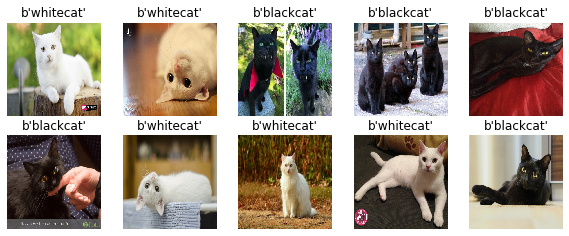

In [ ]:
#hide
show_batch(clf, 10)

In [ ]:
def set_labels(imgs, labels):
    #         labels_new = tf.strings.to_number(
    #             labels,
    #             out_type=tf.dtypes.float32,
    #         )
    labels_new = labels
    imgs = tf.ensure_shape(imgs, (512, 512, 3))

    return imgs, labels_new

In [ ]:
data1 = data.map(set_labels)

In [ ]:
tensor = tf.ensure_shape(data, shape)

<MapDataset shapes: (<unknown>, ()), types: (tf.float32, tf.float32)>

In [ ]:
data1

<MapDataset shapes: ((512, 512, 3), ()), types: (tf.float32, tf.string)>

In [ ]:
for e in data1.take(1):
    print(e[0].shape)

(512, 512, 3)


# Detect

## from_xml
### Steps:
    . list annotations
    . read and parse annotations
    . read images
    . return images and annotations
### folder structure

><pre>/root
    /image_folder
    /annotation_folder</pre>

In [ ]:
class Detect(object):

    def __init__(self):
        self.CLASS_NAMES = None

    def from_xml(self, path: Union[str, pathlib.Path]):
        """Load dataset from given path.
        Args:
            path: string, path of folder containing dataset.
        Returns: image, label -> tf.data.Dataset prefetched with tf.data.AUTOTUNE
        """
        assert isinstance(path, (str, pathlib.Path))
        path = pathlib.Path(path)
        remove_dsstore(path)

        list_folders = tf.data.Dataset.list_files(str(path / '*'))
        list_images = self._get_image_list(str(path))

        self.CLASS_NAMES = tuple(get_basename(e).numpy() for e in list_folders)

        data = list_images.map(self._process_path, num_parallel_calls=AUTOTUNE)
        data = data.prefetch(AUTOTUNE)
        return data